In [1]:
import sys
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

sys.path.append("../src/")
from Network_Validator_Main import main

DTALite, version 0.8.1



In [2]:
%run ../src/Network_Validator_Main.py

Subdirectories:
../data/
GMNS Network Validator
Working directory: ../data/
Using node file: ../data/node.csv
Using link file: ../data/link.csv
Using demand file: ../data/demand.csv
Validation level: 7

Running validation at Readiness Level 7...

SUCCESS: Zone centroids are correctly listed in non-decreasing order at the beginning of the file

First through node identified as node_id=235

Found 234 zone centroids out of 8521 total nodes

First through node identified as node_id=235

Found 235 unique zone IDs in node file
Found 234 unique zone IDs in demand file

SUCCESS: All zones in demand file exist in node file
Copied settings.csv and NEXTA.exe to ../data
File found: ../data\od_performance.csv

OD pairs with impossibly low distance ratios (network distance shorter than straight line):
  O=175, D=208, Network=0.01km, Straight=1.84km, Ratio=0.002998
  O=208, D=175, Network=0.01km, Straight=1.84km, Ratio=0.004350
  O=78, D=7, Network=0.02km, Straight=2.04km, Ratio=0.007946
  O=7, D=78,

In [4]:
!pip install geopandas networkx matplotlib shapely

  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached matplotlib-3.10.8-cp312-cp312-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
Using cached networkx-3.6.1-py3-none-any.whl (2.1 MB)
Using cached matplotlib-3.10.8-cp312-cp312-win_amd64.whl (8.1 MB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------------------ --- 1.6/1.7 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 7.8 MB/s  0:00:00
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp312-cp312-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp312-cp312-win_am

In [5]:
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

In [12]:
# Read the CSV file into a DataFrame
df_demand = pd.read_csv('../data/demand.csv')
df_link = pd.read_csv('../data/link.csv')
df_node = pd.read_csv('../data/node.csv')
df_google_maps_od_distance = pd.read_csv('../data/google_maps_od_distance.csv')
df_inaccessible_od = pd.read_csv('../data/inaccessible_od.csv')
df_destination_accessibility = pd.read_csv('../data/destination_accessibility.csv')
df_link_performance = pd.read_csv('../data/link_performance.csv')
df_od_performance = pd.read_csv('../data/od_performance.csv')
df_origin_accessibility = pd.read_csv('../data/origin_accessibility.csv')
df_problem_volume_links = pd.read_csv('../data/problem_volume_links.csv')
df_problematic_od_distances = pd.read_csv('../data/problematic_od_distances.csv')
df_route_assignment = pd.read_csv('../data/route_assignment.csv')
df_sample_mode_type = pd.read_csv('../data/sample_mode_type.csv')
df_sample_settings = pd.read_csv('../data/sample_settings.csv')
df_settings = pd.read_csv('../data/settings.csv')
df_system_performance = pd.read_csv('../data/system_performance.csv')
df_TAP_log = pd.read_csv('../data/TAP_log.csv')


In [16]:
from shapely import wkt

# 1. Chargement des CSV
df_nodes = df_node.copy()
df_links = df_link.copy()


# 2. Conversion de la colonne texte 'geometry' en objets géométriques réels
# C'est l'étape clé : on transforme le texte "POINT(..)" en objet Point()
df_nodes['geometry'] = df_nodes['geometry'].apply(wkt.loads)
df_links['geometry'] = df_links['geometry'].apply(wkt.loads)

# 3. Création des GeoDataFrames
gdf_nodes = gpd.GeoDataFrame(df_nodes, geometry='geometry', crs="WGS84")
gdf_links = gpd.GeoDataFrame(df_links, geometry='geometry', crs="WGS84")
# On définit l'ID comme index (plus rapide pour NetworkX)
gdf_nodes.set_index('node_id', inplace=True)
gdf_links.set_index('link_id', inplace=True)

print("Données chargées et géométries reconnues !")
gdf_links.head()


Données chargées et géométries reconnues !


,from_node_id,to_node_id,dir_flag,length,vdf_length_mi,free_speed,vdf_free_speed_mph,vdf_fftt,vdf_toll,link_type,vdf_alpha,vdf_beta,vdf_plf,lanes,capacity,ref_volume,obs_volume,geometry
link_id,,,,,,,,,,,,,,,,,,
25311,1,1185,1,0.0,0.0,15,9.320568,0.0,0,0,0.5,1.5,1,1,99999,0.0,0,"LINESTRING (-87.88853 42.99647, -87.88863 42.9..."
25578,1,1186,1,0.0,0.0,15,9.320568,0.0,0,0,0.5,1.5,1,1,99999,0.0,0,"LINESTRING (-87.88853 42.99647, -87.88969 42.9..."
25313,1,1187,1,0.0,0.0,15,9.320568,0.0,0,0,0.5,1.5,1,1,99999,0.0,0,"LINESTRING (-87.88853 42.99647, -87.88835 43.0..."
25580,1,1427,1,0.0,0.0,15,9.320568,0.0,0,0,0.5,1.5,1,1,99999,0.0,0,"LINESTRING (-87.88853 42.99647, -87.89028 42.9..."
25582,1,1428,1,0.0,0.0,15,9.320568,0.0,0,0,0.5,1.5,1,1,99999,0.0,0,"LINESTRING (-87.88853 42.99647, -87.88876 42.9..."


Graphe NetworkX créé avec 8521 nœuds et 30747 arêtes.


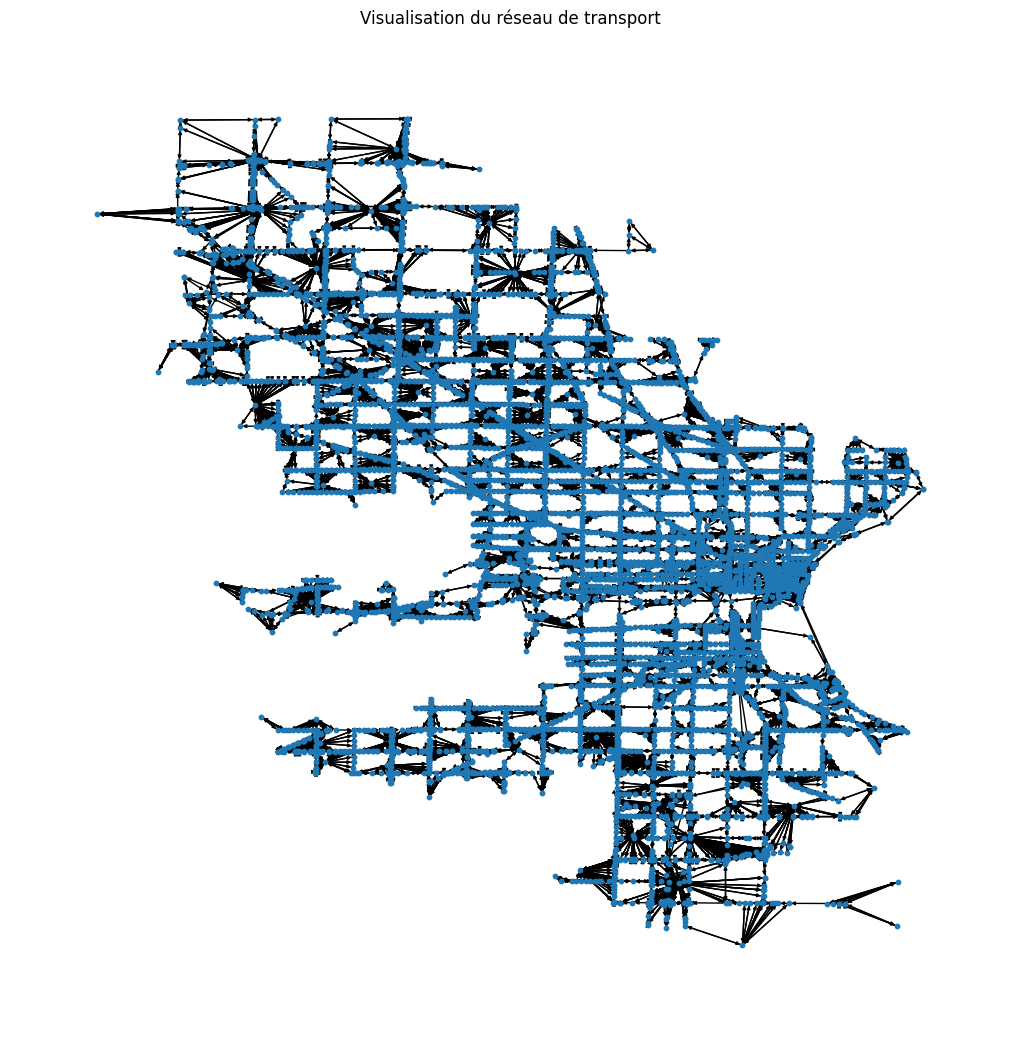

In [17]:
 #4. Création du graphe NetworkX
G = nx.DiGraph()
for idx, row in gdf_nodes.iterrows():
    G.add_node(idx, geometry=row['geometry'], **row.drop('geometry').to_dict())
for idx, row in gdf_links.iterrows():
    start_node = row['from_node_id']
    end_node = row['to_node_id']
    G.add_edge(start_node, end_node, geometry=row['geometry'], **row.drop(['geometry', 'from_node_id', 'to_node_id']).to_dict())
print("Graphe NetworkX créé avec {} nœuds et {} arêtes.".format(G.number_of_nodes(), G.number_of_edges()))
# 5. Visualisation simple
plt.figure(figsize=(10, 10))
pos = {node: (data['geometry'].x, data['geometry'].y) for node, data in G.nodes(data=True)}
nx.draw(G, pos, node_size=10, arrowsize=5)
plt.title("Visualisation du réseau de transport")
plt.show()
# --- IGNORE ---